In [385]:
import lhapdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
import vegas

In [711]:
CF = 4./3.
CA = 3.
dA = 8.
dF = 3.
rho0 = 0.17 /5.076**3
N = 2
Norm = N* np.pi*CF/dA * rho0
L2 = 0.2**2
mu2 = L2*1.0
r0 = 1.12*5.076
@np.vectorize
def alphas(q2):
    return 4*np.pi/9./np.log(np.max([q2/L2,np.e]))

In [712]:
def Tphig(q2):
    return Norm*alphas(q2)/(q2+L2)  

#qhat
def qhat(Q2):
    return quad(Tphig, 0., Q2)[0]

In [713]:
A=208
print("qhat_F(Q=2 GeV) = {:1.3f} GeV2/fm".format(qhat(2*82)*5.076))

qhat_F(Q=2 GeV) = 0.031 GeV2/fm


In [714]:
def Rad_GB(x, k2, q2, phi):
    mu2 = L2
    qx = np.sqrt(q2)
    qy = 0.
    k = np.sqrt(k2)
    kx = k*np.cos(phi)
    ky = k*np.sin(phi)
    # A
    Ax = kx - qx
    Ay = ky - qy
    A2 = Ax**2 + Ay**2 + mu2
    Ax /= A2
    Ay /= A2
    # B
    Bx = kx - x*qx
    By = ky - x*qy
    B2 = Bx**2 + By**2 + mu2
    Bx /= B2
    By /= B2    
    # C
    Cx = kx/(k2 + mu2)
    Cy = ky/(k2 + mu2)
    
    # M2
    M11 = (Ax-Bx)**2 + (Ay-By)**2
    M22 = (Ax-Cx)**2 + (Ay-Cy)**2
    M12 = (Ax-Bx)*(Ax-Cx) + (Ay-By)*(Ay-Cy)
    
    return (M11*CF + M22*CF + (CA-2*CF)*M12)

In [749]:
xQ = 0.5
EP = 100*np.sqrt(2)
Ep = EP * xQ
def xdep(x):
    return 1

def Phi(a,b,c,d,L):
    return xdep((a+c)/2.) * np.cos(L*(a-c))\
         + xdep((b+d)/2.) * np.cos(L*(b-d))\
         - xdep((a+d)/2.) * np.cos(L*(a-d))\
         - xdep((b+c)/2.) * np.cos(L*(b-c))

def Rad_Fs(x, k2, q2, phi):
    mu2 = L2
    qx = np.sqrt(q2)
    qy = 0.
    k = np.sqrt(k2)
    kx = k*np.cos(phi)
    ky = k*np.sin(phi)
    Q12 = k2
    Q22 = (kx-x*qx)**2 + (ky-x*qy)**2 
    Q32 = (kx-qx)**2 + (ky-qy)**2 
    G1x = kx/Q12
    G1y = ky/Q12
    G2x = (kx-x*qx)/Q22
    G2y = (ky-x*qy)/Q22
    G3x = (kx-qx)/Q32
    G3y = (ky-qy)/Q32   
    
    
    E0 = 2*x*(1-x)*Ep
    x1 = (Q32-Q12)/2/(1-x)/Ep
    x2 = q2/2/Ep
    x3 = (Q12-Q32)/2/x/Ep
    y1 = Q12/E0
    y2 = Q22/E0
    y3 = Q32/E0
    
    
    return CA*( 
                  (G3x**2+G3y**2)  * Phi(x3, x3+y3, x3, x3+y3, Lavg)
                - (G1x*G3x+G1y*G3y)* Phi(x1, x1+y1, x3, x3+y3, Lavg)
                - (G2x*G3x+G2y*G3y)* Phi(x2, x2+y2, x3, x3+y3, Lavg) 
               ) \
        +  CF*( 
                  (G1x**2+G1y**2)  * Phi(x1, x1+y1, x1, x1+y1, Lavg)
                + (G2x**2+G2y**2)  * Phi(x2, x2+y2, x2, x2+y2, Lavg) 
               ) \
        + (CA-2*CF)*(G1x*G2x+G1y*G2y)* Phi(x1, x1+y1, x2, x2+y2, Lavg)


In [750]:
def dN(X):
    x = 1.-xq
    lnk2, lnq2, phi = X
    q2 = np.exp(lnq2)
    k2 = np.exp(lnk2)
    return Lavg * Tphig(q2)/q2 * alphas(k2)/2/np.pi**2 * x/2.\
           * Rad_Fs(x, k2, q2, phi) * q2 * k2

In [751]:
pTmax = 5
integ = vegas.Integrator([[np.log(.01**2), np.log(pTmax**2)],
                          [np.log(.01**2), np.log(pTmax**2)],
                          [0, 2*np.pi]])



/tmp/ipykernel_28384/2347083863.py:19: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


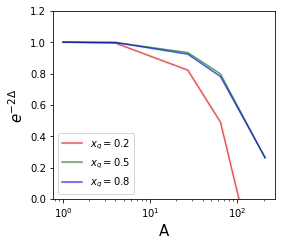

In [752]:
fig, ax = plt.subplots(figsize=(4,3.5), ncols=1, nrows=1, sharex=True, sharey=True)
for xq, c in zip([0.2, 0.5, .8], 'rgb'):
    As = [1, 4, 27, 64, 208]
    Y = []
    for A in As:
        Lavg = (A**(1./3.)-1)*r0*1.5
        delta = integ(dN, nitn=5, neval=2000).val
        Y.append(1-2*delta)

    ax.plot(As, Y, color=c, label=r"$x_q={:1.1f}$".format(xq), alpha=.7, lw=1.5)
ax.set_xlabel(r"A", fontsize=15)

#ax.set_title(r"$x_q={:1.1f}$".format(xq), fontsize=15)
ax.set_ylabel(r"$e^{-2\Delta}$", fontsize=15)
ax.semilogx()

ax.legend()
ax.set_ylim(0,1.2)
plt.tight_layout(True)
plt.subplots_adjust(wspace=0)
plt.savefig("mu2-A.png", dpi=300)

In [11]:
# Collins frag

In [365]:
g = 4.78
mq = 0.3
mg = 0.
ms = 0.792
mpi = 0.137
Const = g**2/8./np.pi**2
alpha=0.5
beta=0
alphas0 = 0.2
# inclusive
@np.vectorize
def k2(z, kT2):
    return z*kT2/(1-z) + ms**2/(1-z) + mpi**2/z
@np.vectorize
def l2(z):
    return (1.-z)/z**2*mpi**2 + mq**2 + (ms**2 - mq**2)/z
@np.vectorize
def Lambda2(z):
    return 3.33**2*z**alpha*(1-z)**beta
@np.vectorize
def Kallen(k2, m1, m2):
    return (k2-(m1+m2)**2) * (k2-(m1-m2)**2)
@np.vectorize
def D1(z, kT2):
    return Const/np.pi/z**2*np.exp(-2*k2(z, kT2)/Lambda2(z)) * (z**2*kT2 + (z*mq+ms-mq)**2)/z**3/(kT2+l2(z))**2
@np.vectorize
def D1i(z):
    return np.pi*z**2*quad(lambda kT2: D1(z, kT2), 0, 100)[0]

# H1
@np.vectorize
def I1g(k20):
    return np.pi*np.sqrt(Kallen(k20, mq, mg))/2/k20
@np.vectorize
def I2g(k20):
    sK = np.sqrt(Kallen(k20, ms, mpi))
    A0 = k20+ms**2-mpi**2-sK
    B0 = k20+ms**2-mpi**2+sK
    return np.pi/2/sK * np.log(A0/B0)
@np.vectorize
def I34g(z, k20):
    return np.pi*np.log(np.sqrt(k20)*(1-z)/ms)
@np.vectorize
def Ha(z, kT2):
    k20 = k2(z, kT2)
    return mq**2/(k20-mq**2) * (3. - mq**2/k20) * I1g(k20)
@np.vectorize
def Hb(z, kT2):
    k20 = k2(z, kT2)
    return 2*ms * I2g(k20)
@np.vectorize
def Hd(z, kT2):
    k20 = k2(z, kT2)
    return 1./(2.*z*kT2) * (
        - I34g(z,k20) * (2*z*mq+ms-mq)
        + I2g(k20) * (  2*z*mq*(k20-mq**2+mpi**2*(1.-2./z))
                   + (ms-mq)*((2*z-1)*k20 -mpi**2 + ms**2 -2*z*mq*(mq+ms) )
                  )
    )
@np.vectorize
def H1(z, kT2):
    k20 = k2(z, kT2)
    return - alphas0/np.pi * Const/np.pi/z**2*np.exp(-2*k20/Lambda2(z))\
           * mpi/(1-z)/(k20-mq**2) * (Ha(z, kT2)+Hb(z, kT2)+Hd(z, kT2))

@np.vectorize
def H1i(z):
    return np.pi*z**2*quad(lambda kT2: H1(z, kT2)/2/mpi*np.sqrt(kT2), 0, 100)[0]

In [366]:
z = np.linspace(1e-1,1-1e-1,11)

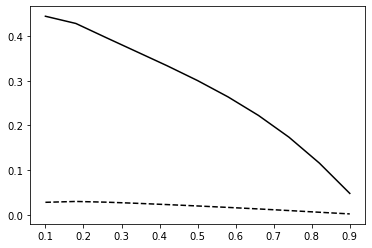

In [382]:
kT2 = 10
D = z*D1i(z)
H = z*H1i(z)
plt.plot(z, D, 'k-')
plt.plot(z, H, 'k--')

In [363]:
def D1_in_medium(xF,pT2):
    def df(X):
        x, lnk2, lnq2, phi_kq, phi_kp = X
        q2 = np.exp(lnq2)
        k2 = np.exp(lnk2)
        zF = xF/(1.-x) # 0<x<1-xF
        w2 = pT2+q2+k2\
           + 2*np.sqrt(pT2*k2)*np.cos(phi_kp) \
           - 2*np.sqrt(pT2*q2)*np.cos(phi_kq-phi_kp) \
           - 2*np.sqrt(k2*q2)*np.cos(phi_kq) \
           
        d1 = H1(zF, w2/zF**2)
        GB = Lavg * Tphig(q2)/q2 * alphas(k2)/2/np.pi**2 * (1+(1-x)**2)/x * Rad(x, k2, q2, phi_kq) * k2 * q2
        return d1 * GB
    integ = vegas.Integrator([[0,1.-xF],
                              [np.log(mu2/100), np.log(10**2)],
                              [np.log(mu2/100), np.log(10**2)],
                              [0, 2*np.pi],
                              [0, 2*np.pi]])
    res = integ(df, nitn=5, neval=4000)
    return res.val

def H1_in_medium(xF,pT2):
    def df(X):
        x, lnk2, lnq2, phi_kq, phi_kp = X
        q2 = np.exp(lnq2)
        k2 = np.exp(lnk2)
        zF = xF/(1.-x) # 0<x<1-xF
        w2 = pT2+q2+k2\
           + 2*np.sqrt(pT2*k2)*np.cos(phi_kp) \
           - 2*np.sqrt(pT2*q2)*np.cos(phi_kq-phi_kp) \
           - 2*np.sqrt(k2*q2)*np.cos(phi_kq) \
           
        d1 = H1(zF, w2/zF**2)
        GB = Lavg * Tphig(q2)/q2 * alphas(k2)/2/np.pi**2 * x/2 * Rad(x, k2, q2, phi_kq) * k2 * q2
        return d1*GB
    integ = vegas.Integrator([[0,1.-xF],
                              [np.log(mu2/100), np.log(10**2)],
                              [np.log(mu2/100), np.log(10**2)],
                              [0, 2*np.pi],
                              [0, 2*np.pi]])
    res = integ(df, nitn=5, neval=4000)
    return res.val

In [367]:
pT2 = 2**2
A=2
Lavg = (A**(1./3.)-1)*r0*1.5
z = np.linspace(1e-1,1-1e-1,11)
dz = z[1]-z[0]

Dp = np.array([D1_in_medium(iz,pT2) for iz in z])
Hp = np.array([H1_in_medium(iz,pT2) for iz in z])


In [368]:
pT2 = 2**2
A=208
Lavg = (A**(1./3.)-1)*r0*1.5
z = np.linspace(1e-1,1-1e-1,11)
dz = z[1]-z[0]
DA = np.array([D1_in_medium(iz,pT2) for iz in z])
HA = np.array([H1_in_medium(iz,pT2) for iz in z])


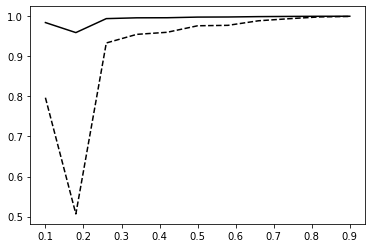

In [373]:
plt.plot(z, (1-2*Hp/Dp), 'k-')
plt.plot(z, (1-2*HA/Dp), 'k--')

(0.0, 1.0)

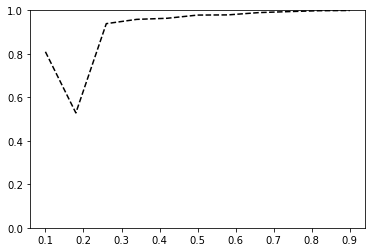

In [374]:
plt.plot(z, (1-2*HA/Dp)/(1-2*Hp/Dp), 'k--')
plt.ylim(0,1)

In [371]:
pT2 = 2**2
A=208
Lavg = (A**(1./3.)-1)*r0*1.5
z = np.linspace(1e-1,1-1e-1,11)
dz = z[1]-z[0]
